In [188]:
import faiss
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import models
import torchvision.transforms as T
from torch import optim

import pytorch_lightning as pl

from tqdm import tqdm

DATASET_DIR = 'imaterialist-fashion-2020-fgvc7'
IMAGE_DIR = os.path.join(DATASET_DIR, 'train')
LABEL_FILE = os.path.join(DATASET_DIR, 'label_descriptions.json')
NUM_CLASSES = 46

def read_image_by_id(image_dir: str, img_id: str, segment=False):
    img = Image.open(os.path.join(image_dir, f"{img_id}.jpg"))
    if segment:
        # img = T.functional.to_tensor(img)
        mask_path = os.path.join(image_dir, f"{img_id}.pth")
        mask = torch.load(mask_path)
        with torch.no_grad():
            img = T.functional.to_tensor(img)
            img *= T.functional.resize(mask, img.shape[1:], antialias=True).cpu()
            img = T.functional.to_pil_image(img)

    return img

class IdDataset(Dataset):
    NUM_CLASSES = 46
    def __init__(self, data, transform=None, image_dir='/kaggle/input/imaterialist-fashion-2020-fgvc7/train'):
        self.image_ids = data['ImageId'].unique()
        self.samples = data.groupby('ImageId').agg({'ClassId': list})
        self.samples = dict(zip(self.samples.index, self.samples['ClassId']))

        self.image_dir = image_dir

        self.transform = transform
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self, key):
        image_id = self.image_ids[key]
        class_ids = self.samples[image_id]
        
        img = Image.open(os.path.join(self.image_dir, f"{image_id}.jpg"))
        label = torch.zeros(IdDataset.NUM_CLASSES, dtype=torch.int32, requires_grad=False)
        label[class_ids] = 1
        
        if self.transform is not None:
            img = self.transform(img)

        return {"img": img, "id": image_id}


In [2]:
EMB_DIR = 'embeddings'
def read_embeddings():
    all_embs = {}
    for embs_fname in os.listdir(EMB_DIR):
        with open(os.path.join(EMB_DIR, embs_fname), 'rb') as f:
            embs = pickle.load(f)
            all_embs[embs_fname[:-4]] = embs
    return all_embs


In [190]:
all_embs = read_embeddings()

In [191]:
def show_images(images, titles, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, len(images), figsize=(24, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img)
        axs[i].set_title(title)

        axs[i].axis('off')


In [192]:
from torchvision.transforms import v2
transforms = v2.Compose([
    T.ToTensor(),
    v2.Resize(size=(224, 224), antialias=True),
])

data = pd.read_csv('./imaterialist-fashion-2020-fgvc7/train.csv')

dataset = IdDataset(data, transform=transforms, image_dir='./imaterialist-fashion-2020-fgvc7/train')
    
train_dataset, val_dataset = random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

import json
class DatasetHelper:
    def __init__(self, data):
        self.image_ids = data['ImageId'].unique()
        self.samples = data.groupby('ImageId').agg({'ClassId': list})
        self.samples = dict(zip(self.samples.index, self.samples['ClassId']))
        with open(LABEL_FILE) as f:
            self.labels = []
            cats = json.load(f)['categories']
            for class_idx in range(NUM_CLASSES):
                cat = next(cat for cat in cats if cat['id'] == class_idx)
                self.labels.append(cat['name'])
    def get_labels(self, img_id: str):
        labels = [self.labels[label_idx] for label_idx in self.samples[img_id]]
        return labels
    def calculate_iou(self, id1: str, id2: str):
        l1 = set(self.get_labels(id1))
        l2 = set(self.get_labels(id2))
        return len(l1.intersection(l2)) / len(l1.union(l2))
    def calc_mean_iou(self, query_id: str, ids: str):
        return np.mean([self.calculate_iou(query_id, id) for id in ids])
dataset_helper = DatasetHelper(data)

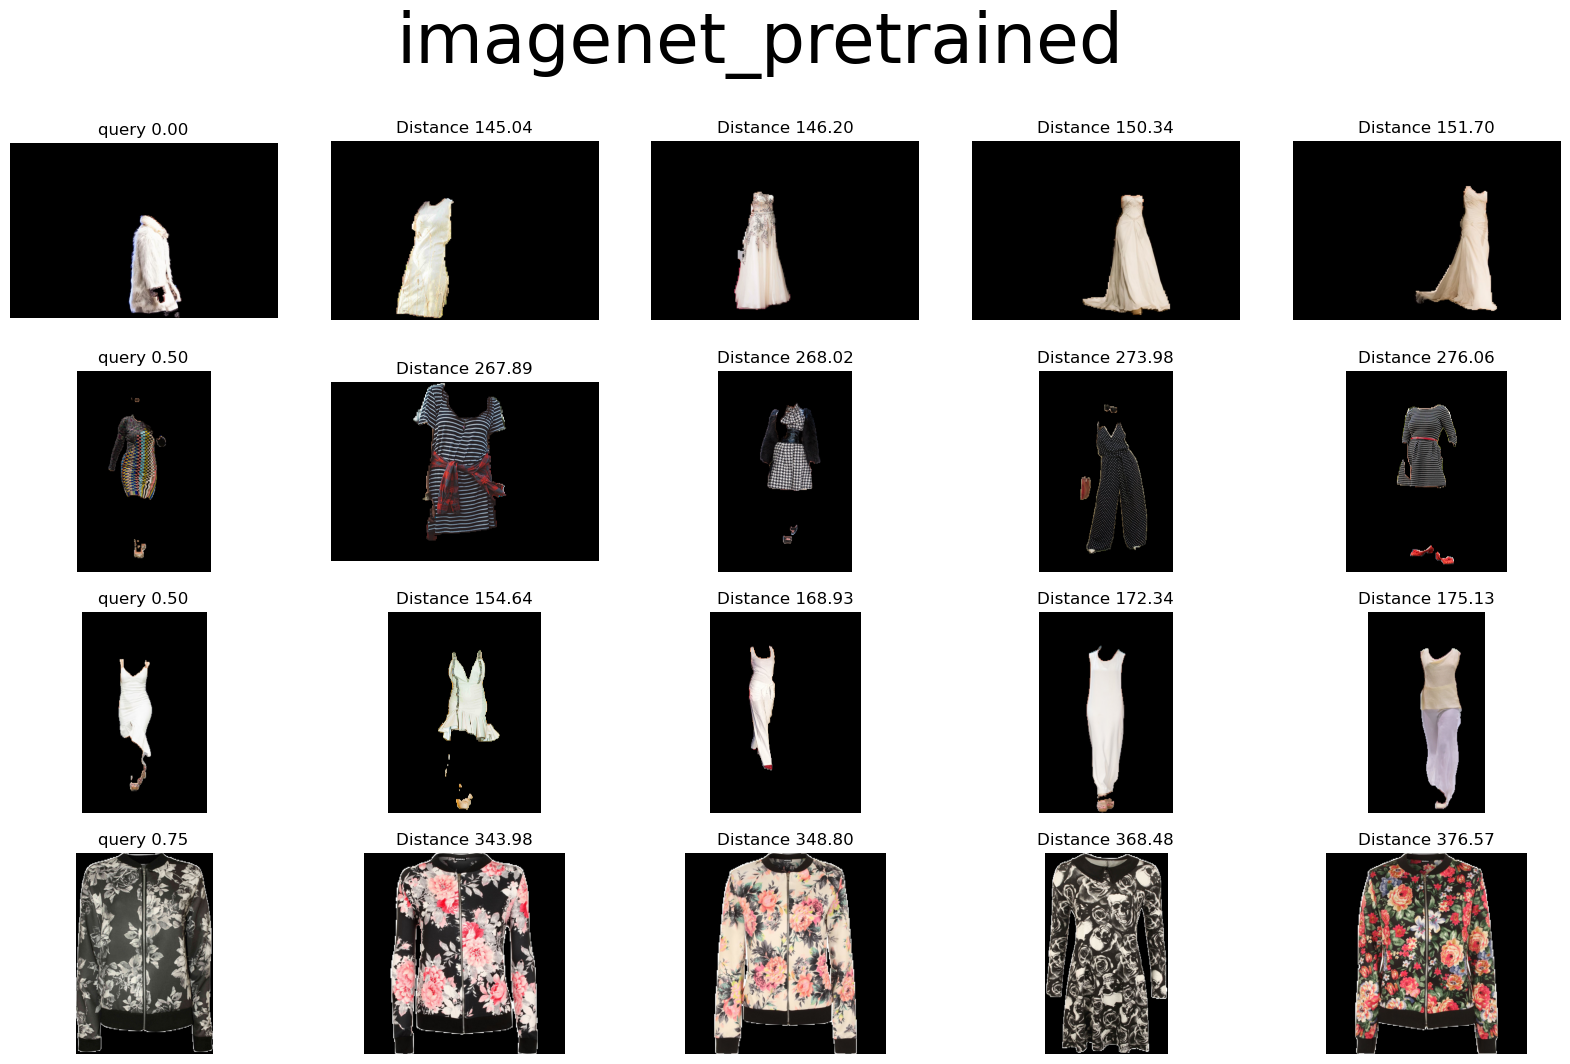

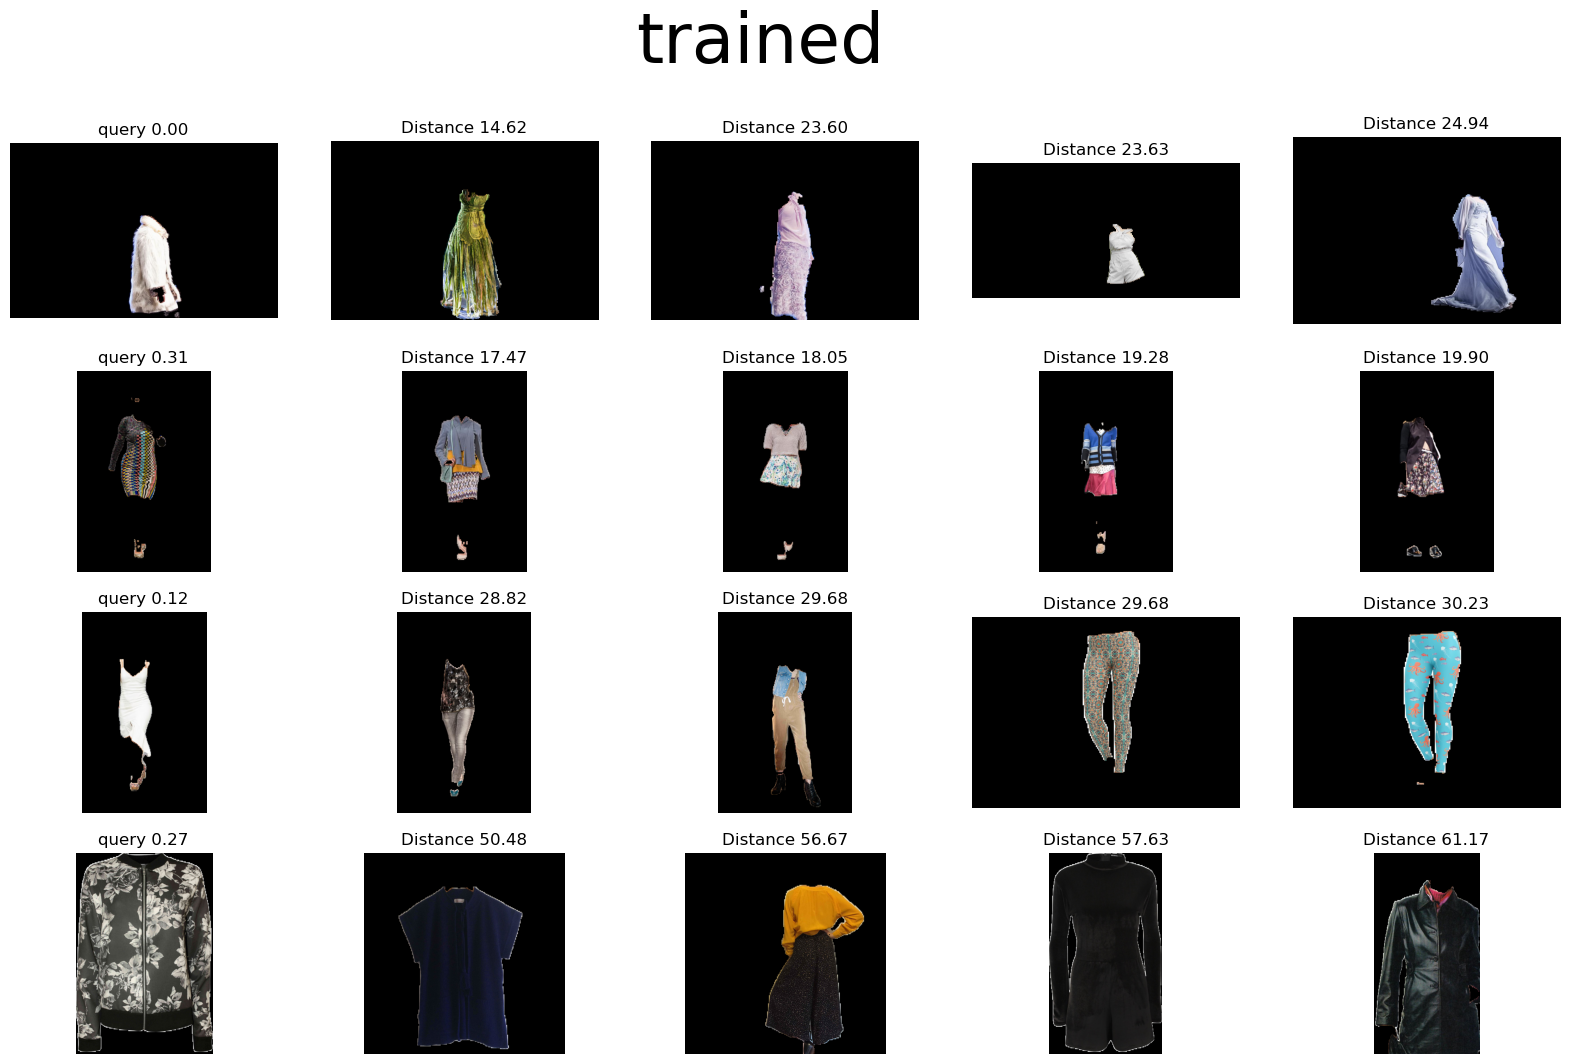

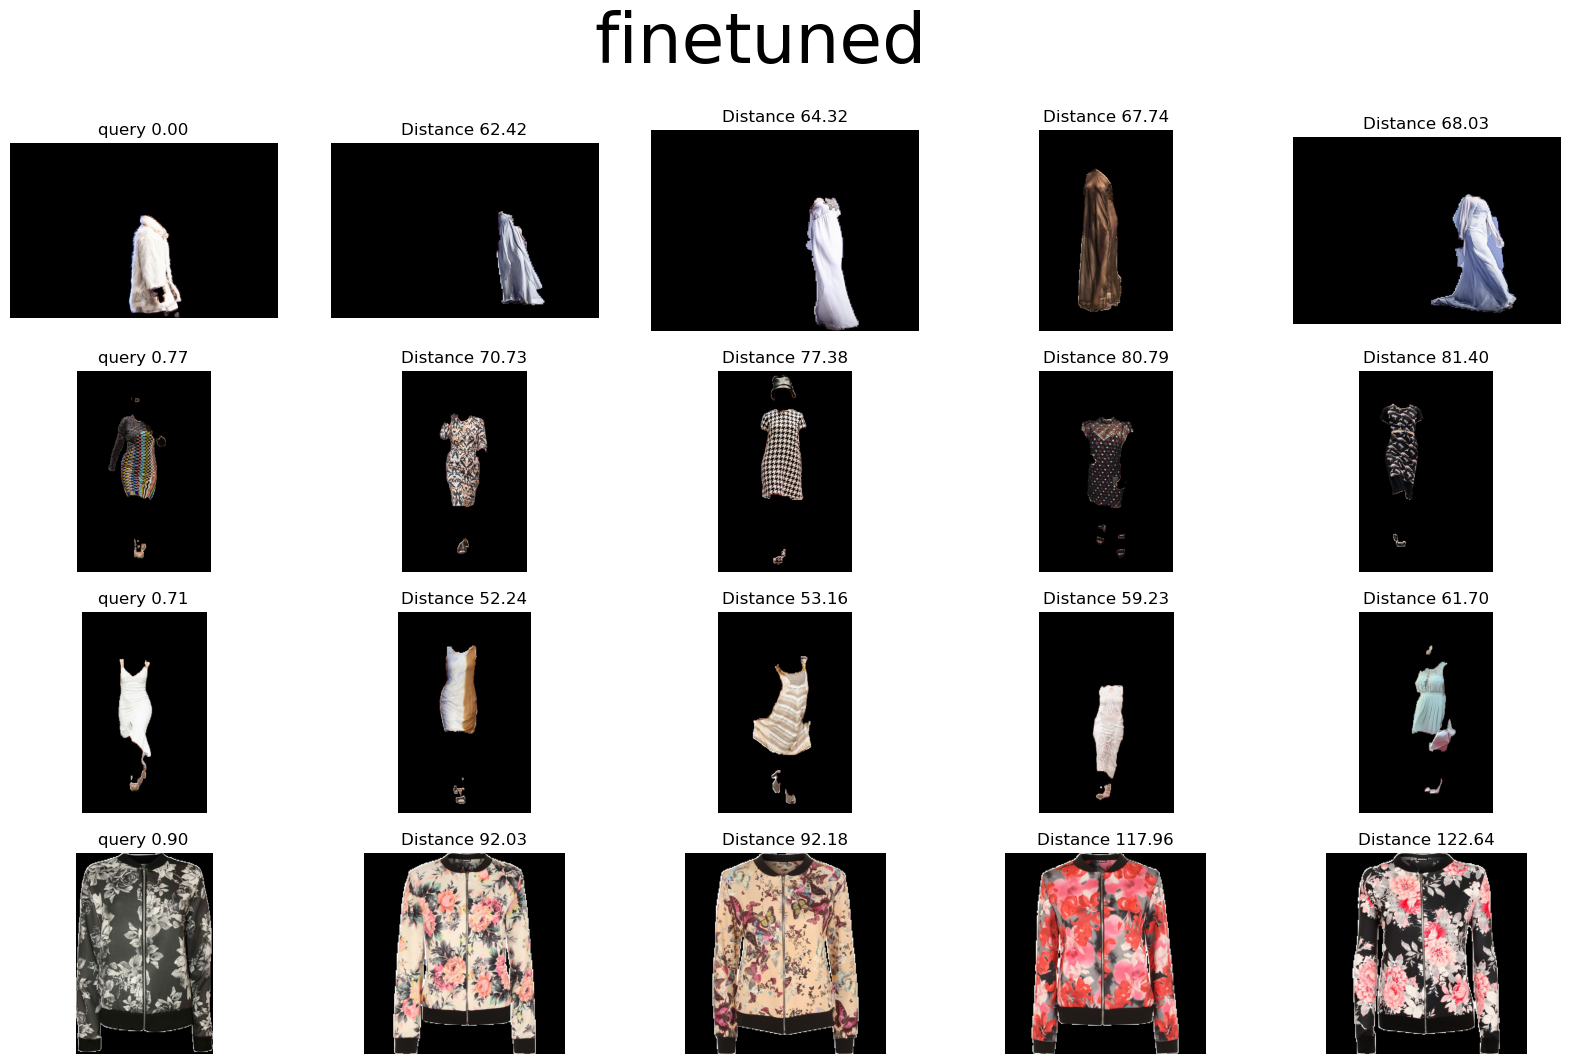

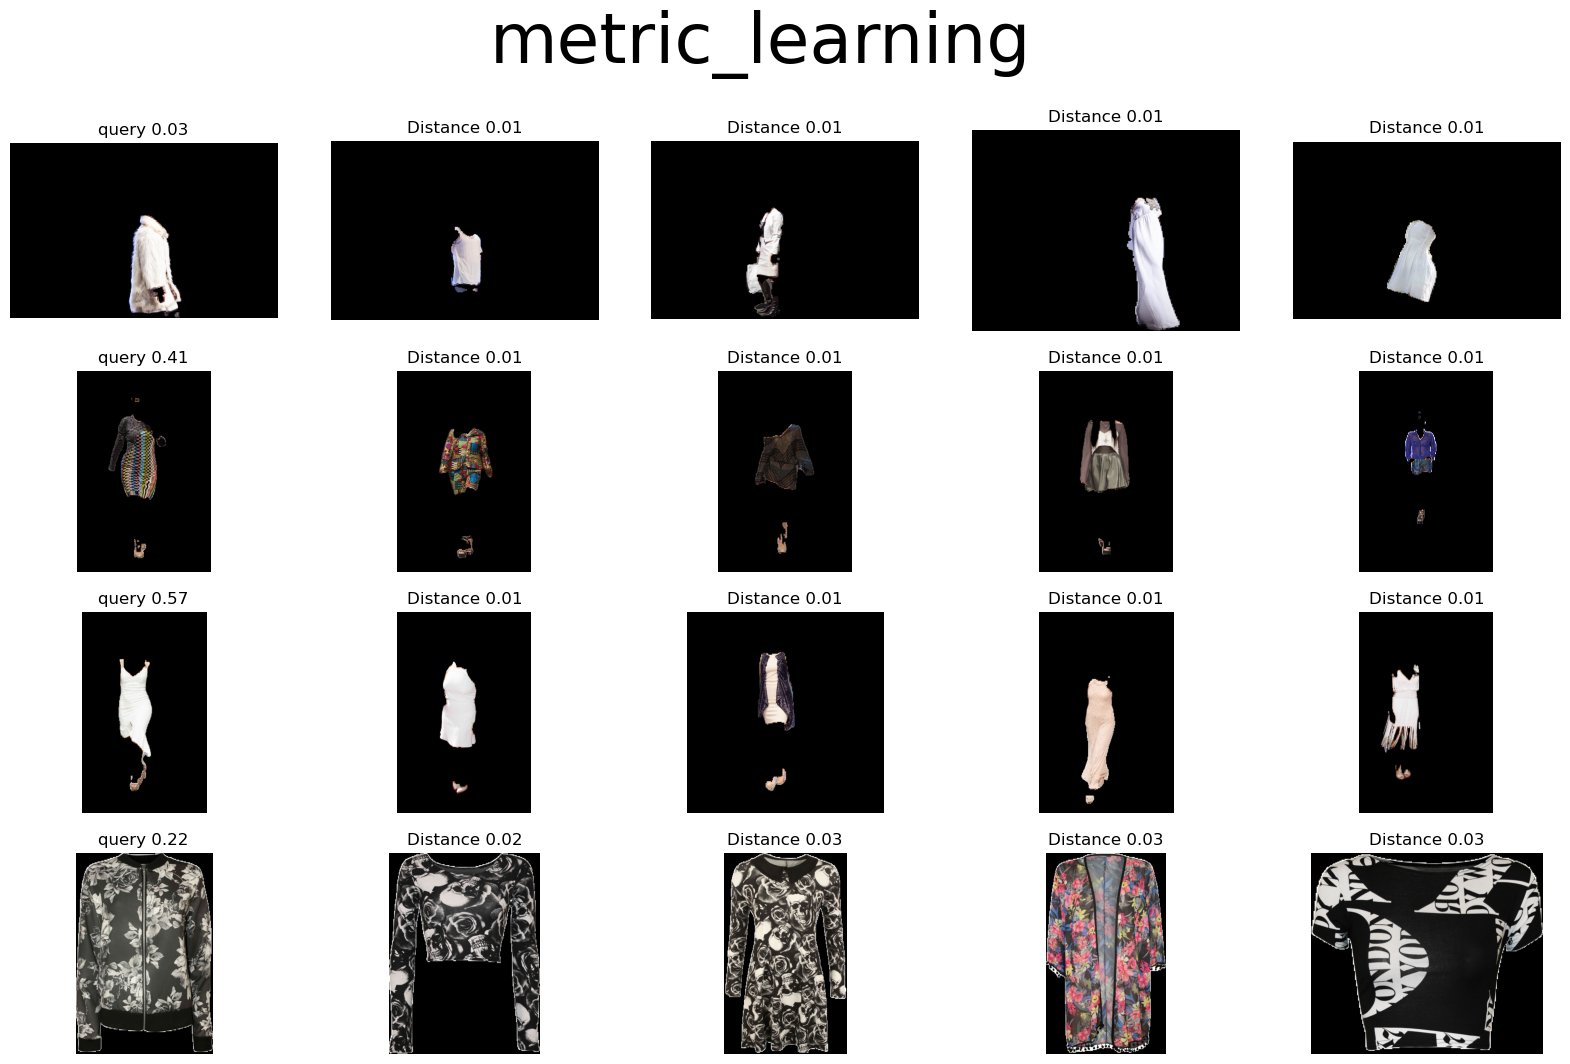

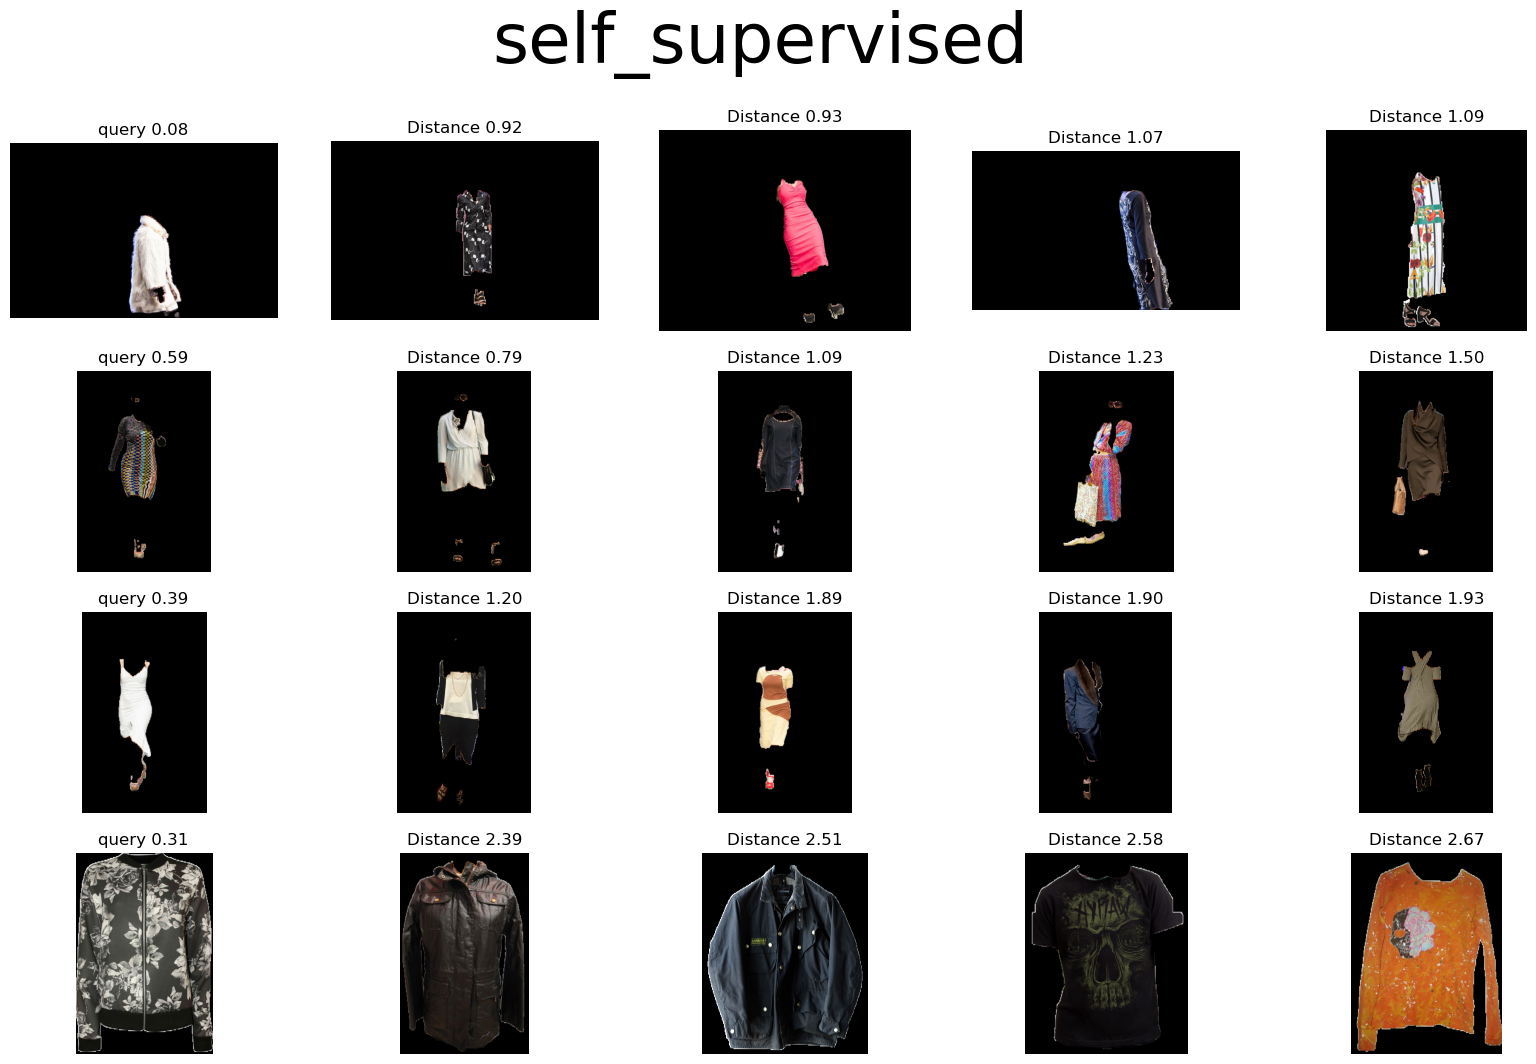

In [193]:
MODELS = ['imagenet_pretrained', 'trained', 'finetuned', 'metric_learning', 'self_supervised']
# MODELS = ['imagenet_pretrained']
NUM_QUERIES_PER_MODEL = 4
NUM_RETRIEVALS_PER_QUERY = 4
# query_ids = np.random.choice(list(all_embs['trained'][1].keys()), NUM_QUERIES_PER_MODEL, replace=False)
for model_name in MODELS:
    train, val = all_embs[model_name]
    train_img_ids, val_img_ids = [list(embs.keys()) for embs in [train, val]]
    train_embs = np.stack([train[img_id] for img_id in train_img_ids])
    val_embs = np.stack([val[img_id] for img_id in val_img_ids])

    apparel_index = faiss.IndexFlatL2(val_embs.shape[1])
    apparel_index.add(train_embs)

    dist, idxs = apparel_index.search(np.array([val[q] for q in query_ids]), NUM_RETRIEVALS_PER_QUERY)

    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(model_name, size=50)
    axes = fig.subplots(len(dist), dist.shape[1] + 1)
    for q_idx in range(len(query_ids)):
        query_id = query_ids[q_idx]
        retrieved_img_ids = [train_img_ids[idx] for idx in idxs[q_idx]]
        retrieved_imgs = [read_image_by_id(IMAGE_DIR, id, segment=True) for id in retrieved_img_ids]
        
        mean_iou = dataset_helper.calc_mean_iou(query_id, retrieved_img_ids)

        show_images([read_image_by_id(IMAGE_DIR, query_id, segment=True)] + retrieved_imgs, 
                          [f'query {mean_iou:.2f}'] + [f"Distance {d:.2f}" for d in dist[q_idx]],
                          axes[q_idx])
    plt.show()


In [194]:
def calculate_iou_stats(models, num_queries_per_model, num_retrievals_per_query):
    query_ids = np.random.choice(list(all_embs['trained'][1].keys()), num_queries_per_model, replace=False)
    iou_stats = {'model': [], 'image_id': [], 'iou': []}
    for model_name in models:
        if model_name == 'random': continue
        train, val = all_embs[model_name]
        train_img_ids, val_img_ids = [list(embs.keys()) for embs in [train, val]]
        train_embs = np.stack([train[img_id] for img_id in train_img_ids])
        val_embs = np.stack([val[img_id] for img_id in val_img_ids])

        apparel_index = faiss.IndexFlatL2(val_embs.shape[1])
        apparel_index.add(train_embs)

        dist, idxs = apparel_index.search(np.array([val[q] for q in query_ids]), num_retrievals_per_query)

        for q_idx in range(len(query_ids)):
            query_id = query_ids[q_idx]
            retrieved_img_ids = [train_img_ids[idx] for idx in idxs[q_idx]]
            
            mean_iou = dataset_helper.calc_mean_iou(query_id, retrieved_img_ids)
            iou_stats['model'].append(model_name)
            iou_stats['image_id'].append(query_id)
            iou_stats['iou'].append(mean_iou)

    if 'random' in models:
        all_train_ids = list(all_embs['finetuned'][0].keys())
        for q_idx in range(len(query_ids)):
            query_id = query_ids[q_idx]
            ious = []
            for _ in range(num_retrievals_per_query):
                retr = str(np.random.choice(all_train_ids))
                ious.append(dataset_helper.calculate_iou(query_id, retr))
            iou_stats['model'].append('random')
            iou_stats['image_id'].append(query_id)
            iou_stats['iou'].append(np.mean(ious))

    return pd.DataFrame(iou_stats)


In [195]:
# iou_stats_full = iou_stats
iou_stats = calculate_iou_stats(['imagenet_pretrained', 'trained', 'finetuned', 'metric_learning', 'self_supervised', 'random'], 500, 5)

In [196]:
# iou_agg_full = iou_agg
iou_agg = iou_stats.groupby('model').agg(iou_mean=('iou', 'mean'), iou_std=('iou', 'std')).reset_index()
iou_agg.sort_values('iou_mean', ascending=False, inplace=True)

In [197]:
iou_agg['segmentation'] = "Yes"

In [198]:
iou_agg = pd.concat([iou_agg, iou_agg_full])

In [199]:
iou_agg['segmentation'].fillna("No", inplace=True)
iou_agg.sort_values('iou_mean', ascending=False, inplace=True)

In [173]:
iou_agg.set_index(['model', 'segmentation']).sort_index()

iou_mean   iou_std
model               segmentation                    
finetuned           No            0.575455  0.218334
                    Yes           0.418322  0.190394
imagenet_pretrained No            0.447025  0.195242
                    Yes           0.397773  0.182805
metric_learning     No            0.330583  0.167783
                    Yes           0.347157  0.160934
random              No            0.238285  0.103284
                    Yes           0.240962  0.102331
self_supervised     No            0.321989  0.144759
                    Yes           0.295948  0.126457
trained             No            0.515403  0.214887
                    Yes           0.368790  0.183131

In [177]:
iou_agg.pivot(index='model', columns='segmentation', values='iou_mean')

segmentation,No,Yes
model,,
finetuned,0.575455,0.418322
imagenet_pretrained,0.447025,0.397773
metric_learning,0.330583,0.347157
random,0.238285,0.240962
self_supervised,0.321989,0.295948
trained,0.515403,0.368790


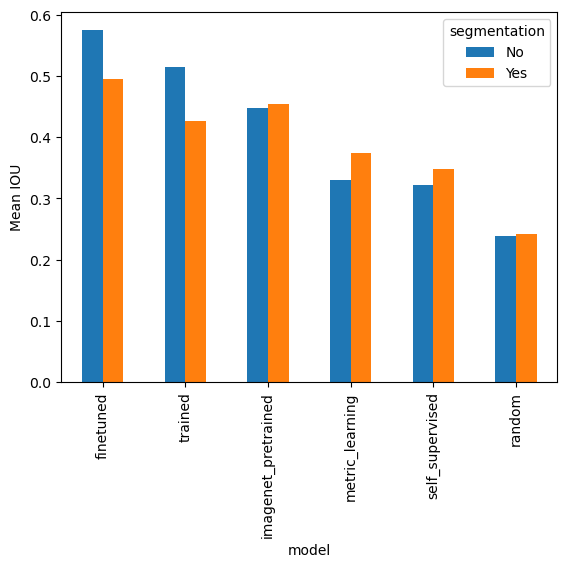

In [204]:
ax = iou_agg.pivot(index='model', columns='segmentation', values='iou_mean').sort_values("No", ascending=False).plot.bar()
ax.set_ylabel('Mean IOU')
plt.show()

In [156]:
iou_agg.pivot()

TypeError: DataFrame.pivot() missing 1 required keyword-only argument: 'columns'

<Axes: xlabel='model,segmentation'>

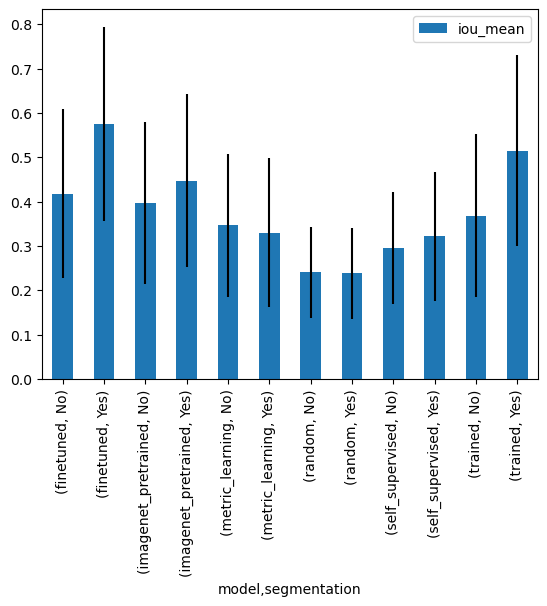

In [153]:
iou_agg.set_index(['model', 'segmentation']).sort_index().plot.bar(yerr='iou_std')

In [145]:
iou_agg.plot.bar(x='model', yerr='iou_std')

ValueError: x must be a label or position

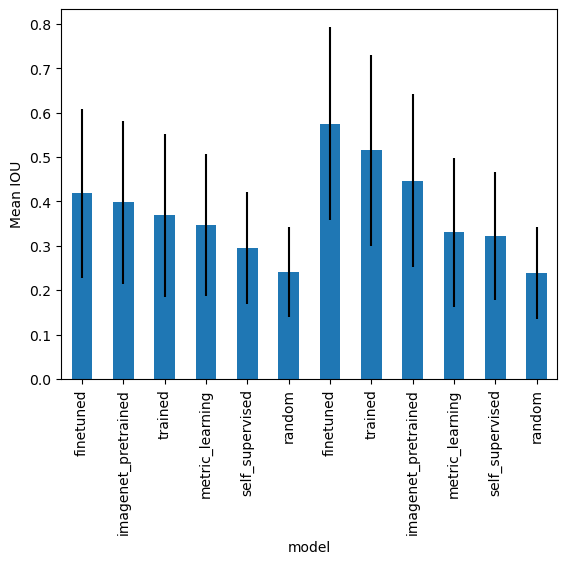

In [142]:
ax = iou_agg.plot('model', 'iou_mean', yerr='iou_std', kind='bar', )
ax.set_ylabel("Mean IOU")
ax.legend().remove()
plt.show()

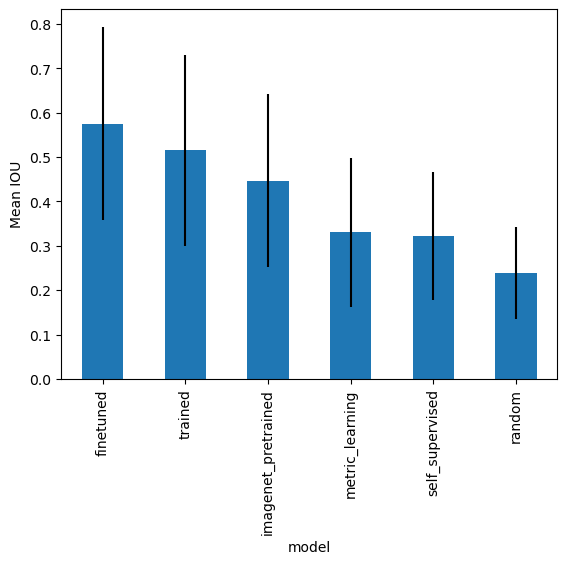

In [120]:
ax = iou_agg.plot('model', 'iou_mean', yerr='iou_std', kind='bar')
ax.set_ylabel("Mean IOU")
ax.legend().remove()
plt.show()